In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime 
from pathlib import Path

import plotly.express as px
import my_utilities
import custom_functions as cf

cfg = my_utilities.__cfg_reading()

KPI_LIST = ['adCost','clicksCounter','impressionsCounter']
PROJECT_PATH = eval(cfg['PROJECT_PATH'])
DATA_PATH = PROJECT_PATH/cfg['DATA_FOLDER']
FILE = cfg['FILE_TO_EXPLORE']
OUTPUT_FILE = cfg['OUTPUT_FILE']

In [2]:
amazon = pd.read_csv(DATA_PATH/FILE)
amazon.sort_values(by='calDate', inplace=True, ignore_index=True)
fb = pd.read_csv('inputs/facebookAdsTest.csv')
fb.sort_values(by='calDate', inplace=True)
google = pd.read_csv('inputs/googleAdsTest.csv')
google.sort_values(by='calDate', inplace=True)
revenues = pd.read_csv('inputs/revenuesTest.csv')
revenues.sort_values(by='calDate', inplace=True)

amazon['calDate'] = pd.to_datetime(amazon['calDate']).dt.date
fb['calDate'] = pd.to_datetime(fb['calDate']).dt.date
google['calDate'] = pd.to_datetime(google['calDate']).dt.date
revenues['calDate'] = pd.to_datetime(revenues['calDate']).dt.date


print(f"AMAZON records: {len(amazon)}")
print(f"FACEBOOK records: {len(fb)}")
print(f"GOOGLE records: {len(google)}")
print(f"REVENUES records: {len(revenues)}")

AMAZON records: 51493
FACEBOOK records: 4962
GOOGLE records: 1311
REVENUES records: 3186


Ci sono duplicati?

In [3]:
assert len(amazon) == len(amazon.drop_duplicates()), "Amazon KO"
assert len(google) == len(google.drop_duplicates()), "Google KO"
assert len(fb) == len(fb.drop_duplicates()), "Facebook KO"
assert len(revenues) == len(revenues.drop_duplicates()), "Revenues KO"

AssertionError: Revenues KO

In [ ]:
revenues = revenues.drop_duplicates().reset_index(drop=True)
assert len(revenues) == len(revenues.drop_duplicates()), "Revenues KO"

# HISTORICAL DEPTH

In [ ]:
print(f"Start Date: {amazon['calDate'].min()}, End Date: {amazon['calDate'].max()}")
print(f"Start Date: {fb['calDate'].min()}, End Date: {fb['calDate'].max()}")
print(f"Start Date: {google['calDate'].min()}, End Date: {google['calDate'].max()}")
print(f"Start Date: {revenues['calDate'].min()}, End Date: {revenues['calDate'].max()}")

min_date = min([amazon['calDate'].min(),fb['calDate'].min(),google['calDate'].min()])


Start Date: 2022-10-20, End Date: 2023-02-20
Start Date: 2019-03-03, End Date: 2023-01-10
Start Date: 2021-08-02, End Date: 2023-02-14
Start Date: 2018-08-26, End Date: 2023-02-13


Ci sono delle revenues precedenti alla prima data di partenza delle prime campagne...errore? Andiamo ad analizzare quei dati

In [ ]:
revenues_out = revenues[revenues['calDate']<min_date]
revenues_out.head(5)

,calDate,connectionStream,totDailyGrossRevenue
0,2018-08-26,1.amazon_seller,32.0
1,2018-08-27,1.amazon_seller,0.0
2,2018-08-28,1.amazon_seller,0.0
3,2018-08-29,1.amazon_seller,0.0
4,2018-08-30,1.amazon_seller,0.0


In [ ]:
fig = px.line(revenues_out, x="calDate", y="totDailyGrossRevenue", color='connectionStream', title="Revenues over Time")
fig.show()
revenues_out['cumsum_totDailyGrossRevenue'] = revenues_out.groupby('connectionStream')['totDailyGrossRevenue'].cumsum().round(0)
#cumulative
fig = px.line(revenues_out, x="calDate", y="cumsum_totDailyGrossRevenue", color='connectionStream', title="Cumulative Revenues")
fig.show()

Sembrano trascurabili, quanto pesano sul totale?

In [4]:
print(revenues_out['totDailyGrossRevenue'].sum()/revenues['totDailyGrossRevenue'].sum())

NameError: name 'revenues_out' is not defined

Sono c.ca 5 basis point, rimuovo

In [28]:
revenues = revenues[revenues['calDate']>=min_date].reset_index(drop=True)
revenues.head()

NameError: name 'min_date' is not defined

In [6]:
print('-----------------------')
print('CalDate - Count')
print(amazon['calDate'].unique().size)
print(google['calDate'].unique().size)
print(fb['calDate'].unique().size)
print('-----------------------')
print('connectionStream - Count')
print(amazon['connectionStream'].unique().size)
print(google['connectionStream'].unique().size)
print(fb['connectionStream'].unique().size)
print('-----------------------')
print('campaignId - Count')
print(amazon['campaignId'].unique().size)
print(google['campaignId'].unique().size)
print(fb['campaignId'].unique().size)

amazon['calDate'] = pd.to_datetime(amazon['calDate']).dt.date


-----------------------
CalDate - Count
122
562
1201
-----------------------
connectionStream - Count
5
1
5
-----------------------
campaignId - Count
576
15
228


In [7]:
print(amazon['connectionStream'].unique())
print(google['connectionStream'].unique())
print(fb['connectionStream'].unique())
print(revenues['connectionStream'].unique())

['2699062280342873.amazon_ads' '1439479395957732.amazon_ads'
 '2515008197398184.amazon_ads' '194623155730586.amazon_ads'
 '4233413705150129.amazon_ads']
['4580834090943463925.google_ads']
['-8632808303847942277.facebook_ads' '5497571559138052347.facebook_ads'
 '-6828721495970743886.facebook_ads' '8896977892796116175.facebook_ads'
 '4626091952120055548.facebook_ads']
['1.amazon_seller' '1.woocommerce']


In [8]:
revenues.groupby('calDate')['connectionStream'].agg(['count','nunique']).reset_index().sort_values(['count'], ascending=False).head(5)

,calDate,count,nunique
1606,2023-01-18,4,2
1085,2021-08-15,2,2
1095,2021-08-25,2,2
1094,2021-08-24,2,2
1093,2021-08-23,2,2


# AMAZON DATASET

Distribuzioni

1th percentile for column adCost is 0.0
25th percentile for column adCost is 0.0
50th percentile for column adCost is 0.73
75.9th percentile for column adCost is 2.73
99th percentile for column adCost is 56.85350000000059
Avg value for column adCost is 3.8817304023586727
1th percentile for column clicksCounter is 0.0
25th percentile for column clicksCounter is 0.0
50th percentile for column clicksCounter is 1.0
75.9th percentile for column clicksCounter is 5.0
99th percentile for column clicksCounter is 81.0
Avg value for column clicksCounter is 6.272632674297607
1th percentile for column impressionsCounter is 2.0
25th percentile for column impressionsCounter is 134.0
50th percentile for column impressionsCounter is 416.0
75.9th percentile for column impressionsCounter is 1331.0
99th percentile for column impressionsCounter is 16979.190000000075
Avg value for column impressionsCounter is 1548.114897676032


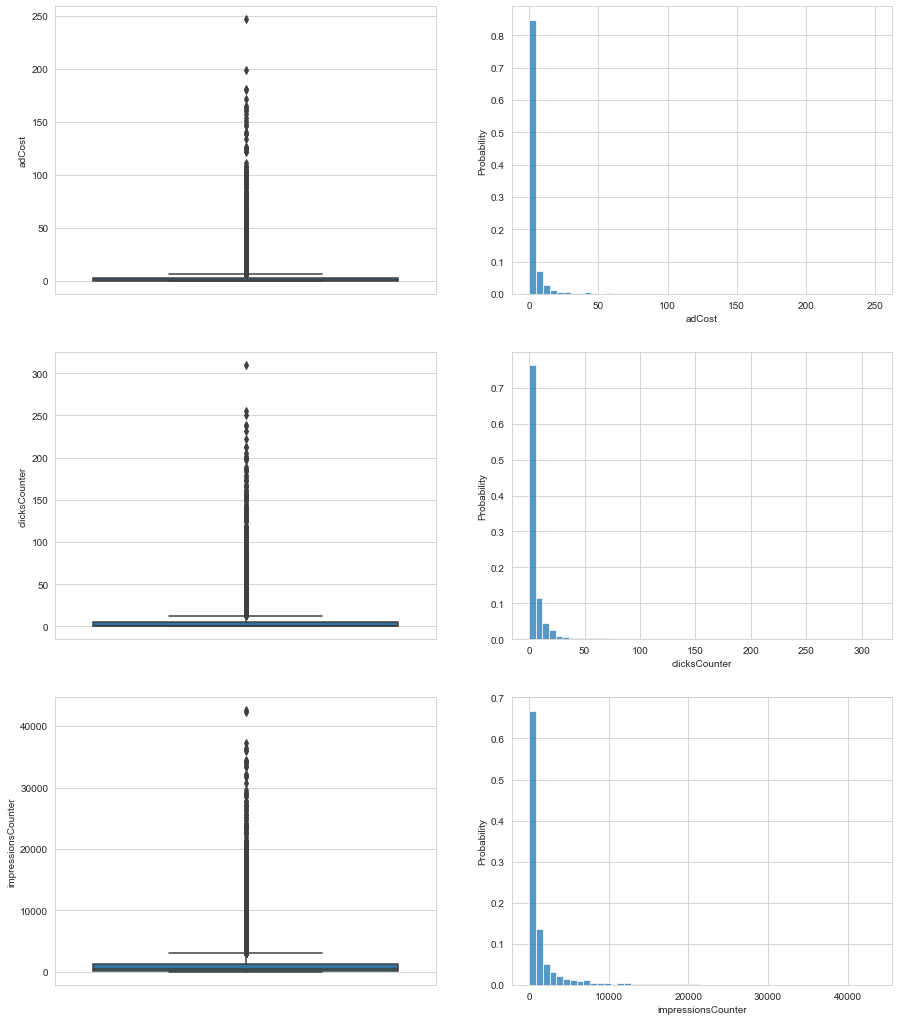

In [26]:
import numpy
columns = KPI_LIST
percentile_list = [1,25,50,75.90,99]

cf.print_box_histplot(amazon, columns, percentile_list)

Ci sono dei connectionStream che hanno sempre costo zero?

In [12]:
cstream_nocost = list(set(amazon['connectionStream'].unique()) - set(amazon[amazon['adCost']!=0]['connectionStream'].unique()))

Vediamo se ha senso tenerli. Guardo se hanno dei click o delle impression

In [13]:
kpis = ['clicksCounter','impressionsCounter']
for cstream in cstream_nocost:
    for kpi in kpis:
        cnt = len(amazon[(amazon['connectionStream'] == cstream) & (amazon[kpi] !=0)])
        print(f'ConnectionStream {cstream}, KPI: {kpi}, occurrencies != 0: {cnt}')


ConnectionStream 194623155730586.amazon_ads, KPI: clicksCounter, occurrencies != 0: 0
ConnectionStream 194623155730586.amazon_ads, KPI: impressionsCounter, occurrencies != 0: 0
ConnectionStream 2515008197398184.amazon_ads, KPI: clicksCounter, occurrencies != 0: 0
ConnectionStream 2515008197398184.amazon_ads, KPI: impressionsCounter, occurrencies != 0: 0


Posso quindi droppare i 2 connectionStream

In [14]:
amazon = amazon[~amazon['connectionStream'].isin(cstream_nocost)].reset_index(drop=True)

Alla stessa maniera provo a vedere se ci sono delle campagne che posso rimuovere

In [15]:
campaign_nocost = list(set(amazon['campaignId'].unique()) - set(amazon[amazon['adCost']!=0]['campaignId'].unique()))
kpis = ['clicksCounter','impressionsCounter']
campaign_to_drop = []

for cmp in campaign_nocost:
    sum_cmp=0
    for kpi in kpis:
            sum_cmp += amazon[(amazon['campaignId'] == cmp)][kpi].sum()
    if sum_cmp == 0:
        campaign_to_drop.append(cmp)

print(len(campaign_to_drop), len(campaign_nocost))
print(set(campaign_nocost) - set(campaign_to_drop))

204 217
{61465538915264, 165000991178821, 279545109772517, 188816844390474, 223338408686989, 257763926801360, 82356915902581, 66973317334166, 67295277685463, 260639707967416, 9921629124025, 40521257929852, 145939210776191}


Scopro che le 13 campagne sopra, sono campagne a cui non è stato erogato alcun costo, che hanno 0 click ma hanno delle impression !=0. 


Nel link: https://sell.amazon.it/pubblicita scopro che le impression non si pagano: 


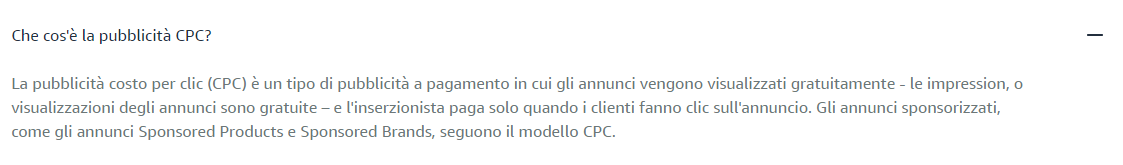 


Pertanto decido di droppare solo quelle che hanno anche impression a 0

In [16]:
amazon = amazon[~amazon['campaignId'].isin(campaign_to_drop)].reset_index(drop=True)
amazon

,calDate,connectionStream,adCost,campaignId,clicksCounter,impressionsCounter
0,2022-10-20,2699062280342873.amazon_ads,0.00,140055347282303,0,0
1,2022-10-20,2699062280342873.amazon_ads,0.00,171084796509030,0,0
2,2022-10-20,2699062280342873.amazon_ads,0.00,59819269096534,0,0
3,2022-10-20,2699062280342873.amazon_ads,0.00,210292757224305,0,0
4,2022-10-20,1439479395957732.amazon_ads,0.00,40521257929852,0,0
...,...,...,...,...,...,...
25250,2023-02-20,4233413705150129.amazon_ads,0.00,35297819496651,0,0
25251,2023-02-20,4233413705150129.amazon_ads,2.43,192007063189480,5,1085
25252,2023-02-20,4233413705150129.amazon_ads,0.00,35155419391279,0,0
25253,2023-02-20,4233413705150129.amazon_ads,0.00,172074352090155,0,0


Ovviamente ne tovo ancora (Es.280346389415384) perchè devo andare a vedere riga per riga.

Il che dovrebbe essere equivalente a dire che droppo tutte le righe il cui impressionCounter = 0.


In [17]:
amazon = amazon[amazon['impressionsCounter']!=0].reset_index(drop=True)
amazon

,calDate,connectionStream,adCost,campaignId,clicksCounter,impressionsCounter
0,2022-10-22,4233413705150129.amazon_ads,0.26,10614543823519,1,184
1,2022-10-22,4233413705150129.amazon_ads,0.59,279773866022620,1,306
2,2022-10-22,4233413705150129.amazon_ads,2.29,24343312211156,9,1720
3,2022-10-22,4233413705150129.amazon_ads,0.25,237558349968916,1,244
4,2022-10-22,4233413705150129.amazon_ads,1.02,106526654535988,1,202
...,...,...,...,...,...,...
14192,2023-02-20,4233413705150129.amazon_ads,0.00,219802832720658,0,400
14193,2023-02-20,4233413705150129.amazon_ads,4.46,245690493398216,9,2620
14194,2023-02-20,4233413705150129.amazon_ads,2.38,220927585173718,7,1121
14195,2023-02-20,4233413705150129.amazon_ads,2.43,192007063189480,5,1085


Adesso guardo se a parità di calDate, campaignId ci sono più valori

In [18]:
amazon.groupby(['calDate', 'campaignId'])['connectionStream'].agg(['count','nunique']).reset_index().sort_values(['count'], ascending=False).head(5)

,calDate,campaignId,count,nunique
7869,2023-02-08,11745112384230,19,1
8424,2023-02-11,11745112384230,19,1
8240,2023-02-10,11745112384230,19,1
8057,2023-02-09,11745112384230,19,1
6915,2023-02-03,11745112384230,18,1


Ci sono più record a parità di coppia calDate, campaignId, sommo i costi ed i relativi KPI

In [19]:
amazon = amazon.groupby(['calDate', 'connectionStream', 'campaignId'])['adCost','clicksCounter','impressionsCounter'].sum().reset_index()
amazon.tail(5)

,calDate,connectionStream,campaignId,adCost,clicksCounter,impressionsCounter
10257,2023-02-20,4233413705150129.amazon_ads,264372256055596,0.15,1,234
10258,2023-02-20,4233413705150129.amazon_ads,267931548363586,13.50,28,2838
10259,2023-02-20,4233413705150129.amazon_ads,273093702467424,0.97,3,1575
10260,2023-02-20,4233413705150129.amazon_ads,278104283412111,4.20,10,2220
10261,2023-02-20,4233413705150129.amazon_ads,279773866022620,4.58,11,3199


Ci sono discontinuità sulle date?

In [20]:
pd.date_range(start = amazon['calDate'].min(), end = amazon['calDate'].max()).difference(amazon['calDate'].unique())

DatetimeIndex(['2022-10-24', '2022-10-26', '2022-10-29', '2022-10-31',
               '2022-11-01', '2022-11-02', '2022-11-03', '2022-11-10',
               '2022-11-16', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-26', '2022-11-28', '2022-11-30',
               '2022-12-04', '2022-12-06', '2022-12-08', '2022-12-09',
               '2022-12-12'],
              dtype='datetime64[ns]', freq=None)

Ricontrollo le distrubuzioni perchè ho intenzione di fillare le date mancanti con dei valori di default (tendenzialmente mediana)

1th percentile for column adCost is 0.0
25th percentile for column adCost is 0.0
50th percentile for column adCost is 0.72
75.9th percentile for column adCost is 2.76
99th percentile for column adCost is 63.35289999999994
Avg value for column adCost is 3.834839212629123
1th percentile for column clicksCounter is 0.0
25th percentile for column clicksCounter is 0.0
50th percentile for column clicksCounter is 1.0
75.9th percentile for column clicksCounter is 5.0
99th percentile for column clicksCounter is 87.0
Avg value for column clicksCounter is 6.143929058663029
1th percentile for column impressionsCounter is 1.0
25th percentile for column impressionsCounter is 127.0
50th percentile for column impressionsCounter is 405.0
75.9th percentile for column impressionsCounter is 1324.1980000000003
99th percentile for column impressionsCounter is 17808.84999999999
Avg value for column impressionsCounter is 1530.0907230559344


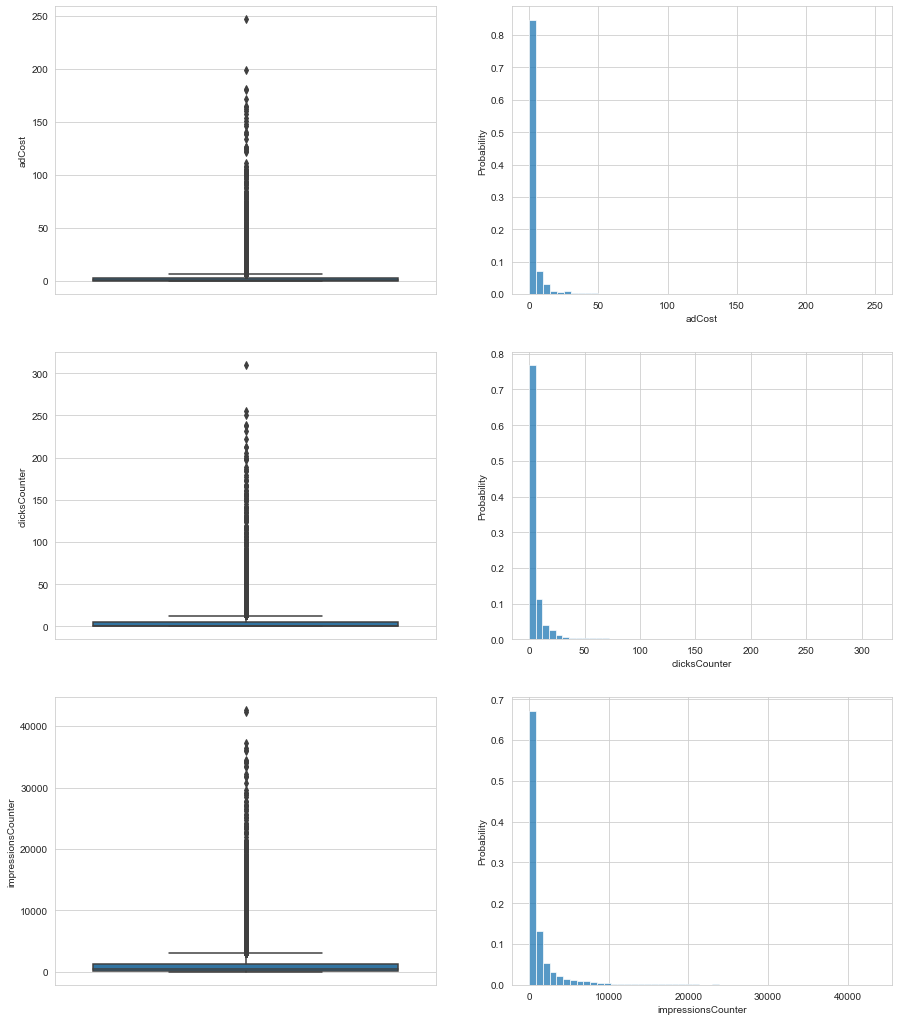

In [21]:
import numpy
columns = ['adCost','clicksCounter','impressionsCounter']
fig, axs = plt.subplots(figsize=(15,18), nrows=len(columns), ncols=2)

for col in columns:
    for perc in [1,25,50,75.90,99]:
        p = numpy.percentile(amazon[col], perc)
        print(f'{perc}th percentile for column {col} is {p}')
    print(f'Avg value for column {col} is {amazon[col].mean()}')
    sns.set_style('whitegrid')
    sns.boxplot(y=col,data=amazon, ax=axs[columns.index(col)][0])
    sns.histplot(data=amazon, x=col, binwidth=round(max(amazon[col])/50,0), ax=axs[columns.index(col)][1], stat='probability', common_norm=False)

Tutti i KPI hanno distribuzioni right skewed, pertanto decido di rimpiazzare i  valori null con il 50 percentile della corrispondente campagna 

In [22]:
amazon_missing = cf.add_missing_combinations(amazon, date_column='calDate', columns=['connectionStream','campaignId'])
#tmp['calDate']= pd.to_datetime(amazon['calDate']).dt.date

CREO UN DIZIONARIO CON TUTTI I 50 PERCENTILI DI TUTTE LE CAMPAGNE PER CIASCUN KPI

Per ciascuna colonna applico quindi il dizionario sopra

In [23]:
columns = ['adCost','clicksCounter','impressionsCounter']
d = cf.create_median_dict(amazon, columns)
for col in columns:
    amazon_missing[col] = amazon_missing['campaignId'].map(d[col])
                                                           
amazon_missing.head(5)

,calDate,connectionStream,campaignId,adCost,clicksCounter,impressionsCounter
0,2022-10-24,4233413705150129.amazon_ads,1428338712105,2.540,12.0,1318.0
1,2022-10-24,4233413705150129.amazon_ads,6562583404860,0.390,1.0,366.5
2,2022-10-24,4233413705150129.amazon_ads,8997035945758,2.690,13.0,3037.0
3,2022-10-24,4233413705150129.amazon_ads,9384896058818,0.700,3.0,337.0
4,2022-10-24,4233413705150129.amazon_ads,10614543823519,1.155,3.0,572.0


Concateno i due Dataframe e controllo che non ci siano date mancanti

In [24]:
amazon = pd.concat([amazon, amazon_missing], ignore_index=True)
amazon.sort_values(by=['calDate'], inplace=True,ignore_index=True)

print(pd.date_range(start = amazon['calDate'].min(), end = amazon['calDate'].max()).difference(amazon['calDate'].unique()))

DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [27]:
#for conn in amazon['connectionStream'].unique():
#    data_plot = amazon[amazon['connectionStream'] == conn]
#    fig, ax = plt.subplots(1, 1, figsize=(17, 7))
#    sns.boxplot(x='campaignId', y='adCost', data=data_plot, ax=ax).set_title(conn)
#    fig.axes[0].tick_params(axis='x', labelrotation=60)
#    fig.show()